In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
%matplotlib inline

In [2]:
h = 10
x = y = np.array([h*i for i in range(64)])


In [3]:
# das_template_x = np.array([2.5*np.sqrt(2)*i for i in range(23)])
# das_template_y = np.array([2.5*np.sqrt(2)*i for i in range(23)])
# das_template_x2 = np.hstack([das_template_x,das_template_x[::-1],das_template_x,das_template_x[::-1]])
# das_template_y2 = np.hstack([das_template_y,das_template_y+das_template_y[-1],das_template_y+2*das_template_y[-1],das_template_y+3*das_template_y[-1]])

# das_x = np.hstack([das_template_x2+i*das_template_x[-1] for i in range(4)])
# das_y = np.hstack([das_template_y2 for i in range(4)])

# offset = (320-np.max(das_x))/2

# das_x += offset
# das_y += offset

# azimuth_template_1 = np.array([[[45 for i in range(23)], [-45 for i in range(23)]] for i in range(2)]).flatten()
# azimuth_template_2 = np.array([[[135 for i in range(23)], [215 for i in range(23)]] for i in range(2)]).flatten()
# das_az = np.hstack([azimuth_template_1, azimuth_template_2, 
#                     azimuth_template_1, azimuth_template_2])

# das_azr = np.deg2rad(das_az)

In [4]:
template = np.linspace(0,320, 65)
template = (template[1:]+template[:-1])/2

das_x = np.hstack([template, template, template,[80 for i in range(len(template))], [160 for i in range(len(template))], [240 for i in range(len(template))]])
das_y = np.hstack([[80 for i in range(len(template))], [160 for i in range(len(template))], [240 for i in range(len(template))],template,template,template])
das_az = np.hstack([[90 for i in range(len(template))], [270 for i in range(len(template))], [90 for i in range(len(template))],[0 for i in range(len(template))], [180 for i in range(len(template))], [0 for i in range(len(template))]])
raz = np.deg2rad(das_az)
das_azr = np.deg2rad(das_az)


In [5]:
nx = ny = 32
t = np.linspace(0,320,nx+1)
s = np.linspace(80,240,17)
s2 = np.linspace(40,280,9)


x = y = (t[:-1]+t[1:]) / 2
xst = yst = (s[:-1]+s[1:]) / 2
xst2 = yst2 = (s2[:-1]+s2[1:]) / 2


xs, ys = np.meshgrid(xst,yst)
xs = xs.flatten()
ys = ys.flatten()

xs2, ys2 = np.meshgrid(xst2,yst2)
xs2 = xs2.flatten()
ys2 = ys2.flatten()

# np.random.seed(43771120)
# xs = np.random.uniform(0,320,128)
# ys = np.random.uniform(0,320,128)

In [6]:
xs2

array([ 55.,  85., 115., 145., 175., 205., 235., 265.,  55.,  85., 115.,
       145., 175., 205., 235., 265.,  55.,  85., 115., 145., 175., 205.,
       235., 265.,  55.,  85., 115., 145., 175., 205., 235., 265.,  55.,
        85., 115., 145., 175., 205., 235., 265.,  55.,  85., 115., 145.,
       175., 205., 235., 265.,  55.,  85., 115., 145., 175., 205., 235.,
       265.,  55.,  85., 115., 145., 175., 205., 235., 265.])

In [7]:
xs[128+7], ys[128+7]

(155.0, 165.0)

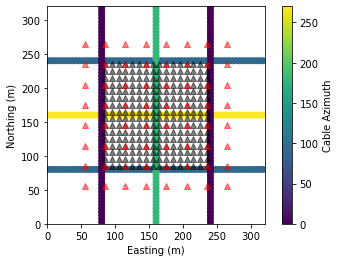

In [8]:
cax = plt.scatter(das_x, das_y,c=das_az)
plt.scatter(xs, ys, marker='^', color='k', alpha=0.5)
plt.scatter(xs2, ys2, marker='^', color='r', alpha=0.5)
#plt.scatter(xs[128+7], ys[128+7], marker='o', color='b', alpha=0.5)

plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Cable Azimuth")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")
plt.savefig("Figures/Setup.pdf")

In [9]:
from scipy.io import loadmat
from scipy.interpolate import RectBivariateSpline as rbs
from scipy.integrate import romb
import scipy.sparse as sp
import os

cscale = 2

generate_kernels = True

raz = np.deg2rad(das_az)

L = 5 #gauge length
ll = np.linspace(-L/2, L/2, 2**5+1)
dl = ll[1]-ll[0]
p1 = das_x[:,np.newaxis]+np.sin(raz[:,np.newaxis])*ll[np.newaxis,:]
p2 = das_y[:,np.newaxis]+np.cos(raz[:,np.newaxis])*ll[np.newaxis,:]


if generate_kernels:
    os.makedirs("Kernels", exist_ok=True)
    crv = loadmat(f"../Curvelet_Basis_Construction/G_{nx}_{ny}.mat")
    G_mat = np.reshape(crv["G_mat"].T, (crv["G_mat"].shape[1], nx, ny))
    crvscales = crv["scales"].flatten()
    cvtscaler = 2.0**(cscale*crvscales)
    G1 = np.zeros((len(raz), G_mat.shape[0]))
    G2 = np.zeros((len(raz), G_mat.shape[0]))
    G3 = np.zeros((len(xs), G_mat.shape[0]))       
    G4 = np.zeros((len(xs2), G_mat.shape[0]))             

    for j in range(G_mat.shape[0]):
        frame = rbs(x,y,G_mat[j])
        #average derivatives of frame along gauge length
        fd1 = romb(frame.ev(p1, p2, dx=1), dl) / L
        fd2 = romb(frame.ev(p1, p2, dy=1), dl) / L
        G1[:,j] = (np.sin(raz)**2*fd1 + 
                  np.sin(2*raz)*fd2/2) / cvtscaler[j]
        G2[:,j] = (np.cos(raz)**2*fd2 + 
                  np.sin(2*raz)*fd1/2) / cvtscaler[j]
        G3[:,j] = frame.ev(xs, ys) / cvtscaler[j]
        G4[:,j] = frame.ev(xs2, ys2) / cvtscaler[j]

    np.save("Kernels/G1.npy", G1)
    np.save("Kernels/G2.npy", G2)
    np.save("Kernels/G3.npy", G3)
    np.save("Kernels/G4.npy", G4)

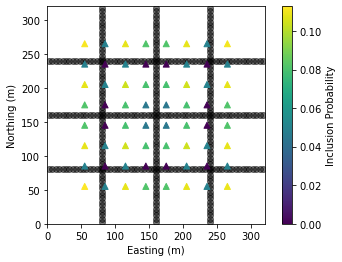

In [10]:
res = np.load("IncoherenceResults/res_inc_4.npy")
plt.scatter(das_x, das_y, c='k', alpha=0.5)
cax = plt.scatter(xs2, ys2, c=res, marker='^')
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Inclusion Probability")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")
plt.savefig("Figures/b4.pdf")

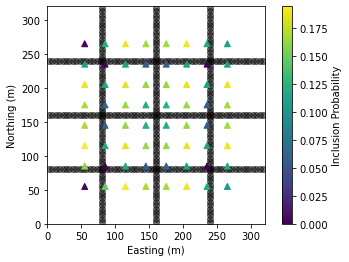

In [11]:
res = np.load("IncoherenceResults/res_inc_8.npy")
plt.scatter(das_x, das_y, c='k', alpha=0.5)
cax = plt.scatter(xs2, ys2, c=res, marker='^')
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Inclusion Probability")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")
plt.savefig("Figures/b8.pdf")

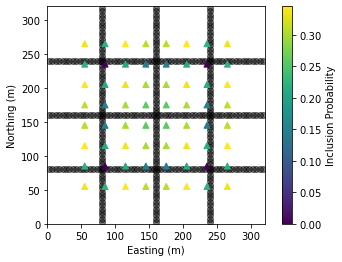

In [12]:
res = np.load("IncoherenceResults/res_inc_16.npy")
plt.scatter(das_x, das_y, c='k', alpha=0.5)
cax = plt.scatter(xs2, ys2, c=res, marker='^')
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Inclusion Probability")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")
plt.savefig("Figures/b16.pdf")

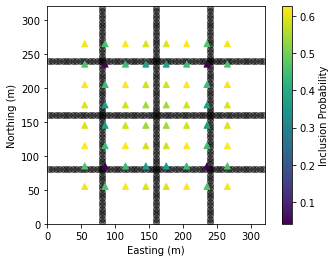

In [13]:
res = np.load("IncoherenceResults/res_inc_32.npy")
plt.scatter(das_x, das_y, c='k', alpha=0.5)
cax = plt.scatter(xs2, ys2, c=res, marker='^')
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Inclusion Probability")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")
plt.savefig("Figures/b32.pdf")

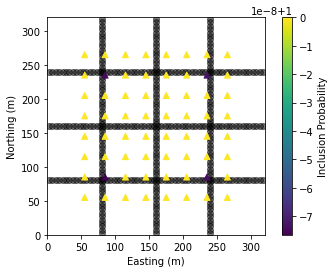

In [14]:
res = np.load("IncoherenceResults/res_inc_64.npy")
plt.scatter(das_x, das_y, c='k', alpha=0.5)
cax = plt.scatter(xs2, ys2, c=res, marker='^')
plt.xlim(0,320)
plt.ylim(0,320)
plt.colorbar(cax, label="Inclusion Probability")
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")
plt.savefig("Figures/b64.pdf")

In [15]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, axis=0):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data, axis=axis)
    return y

def butter_lowpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, [low], btype='low')
    return b, a


def butter_low_filter(data, lowcut, fs, order=5, axis=0):
    b, a = butter_lowpass(lowcut, fs, order=order)
    y = lfilter(b, a, data, axis=axis)
    return y

In [16]:
np.sqrt(2)*320 / 2000 * 8000 # = length of diagonal * approx samples to cross diagonal * assumed samples / s = m / s velocity

1810.1933598375617

In [17]:
shot = np.reshape(np.fromfile("Testing/TestData/shot1.dat", dtype=np.float32), (4001,64,64))
t = np.linspace(0, 0.5, 4001)
shotf = butter_low_filter(shot, 10, 8000)
tf = t[::20]
shotf = shotf[::20,:,:]
tf_freq = 1/(tf[1]-tf[0])

In [18]:
xc = np.linspace(0,320,65)
xc = (xc[:-1]+xc[1:])/2
yc = xc

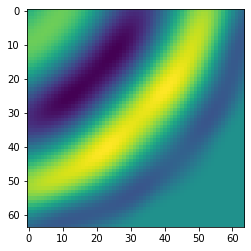

In [19]:
plt.imshow(shotf[101])

In [20]:
from scipy.interpolate import RectBivariateSpline as rbs

In [21]:
shotf_itps = [rbs(xc, yc, s) for s in shotf[:-1]]

In [22]:
exxr = np.array([romb(s.ev(p1, p2, dx=2), dl)/L for s in shotf_itps])
eyyr = np.array([romb(s.ev(p1, p2, dy=2), dl)/L for s in shotf_itps])
exyr = np.array([romb(s.ev(p1, p2, dx=1, dy=1), dl)/L  for s in shotf_itps])
edasr = (np.sin(das_azr)**2*exxr+np.sin(2*das_azr)*exyr+np.cos(das_azr)**2*eyyr) 

uxr = np.array([s.ev(xs2, ys2, dx=1) for s in shotf_itps])
uyr = np.array([s.ev(xs2, ys2, dy=1) for s in shotf_itps])

cuxr = np.array([s.ev(xs, ys, dx=1) for s in shotf_itps])
cuyr = np.array([s.ev(xs, ys, dy=1) for s in shotf_itps])

In [23]:
np.random.seed(94899109)
edasr = edasr+0.1*np.random.normal(0,np.std(edasr),edasr.shape)
uxr = uxr+0.1*np.random.normal(0,np.std(uxr),uxr.shape)
uyr = uyr+0.1*np.random.normal(0,np.std(uyr), uyr.shape)

In [24]:
nfactor = np.std(np.hstack([uxr, uyr]))/np.std(edasr)

In [25]:
edasr = nfactor * edasr
G1 = nfactor * G1
G2 = nfactor * G2

In [26]:
nfactor

33.27499268717693

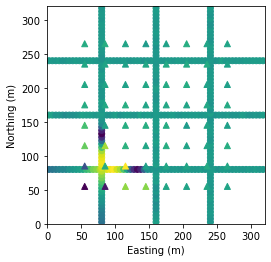

In [27]:
idx = 53
plt.scatter(das_x, das_y,c=edasr[idx])
plt.scatter(xs2, ys2, marker='^', c=uxr[idx])
plt.xlim(0,320)
plt.ylim(0,320)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

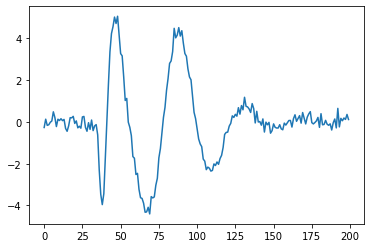

In [28]:
plt.plot(edasr[:,10])

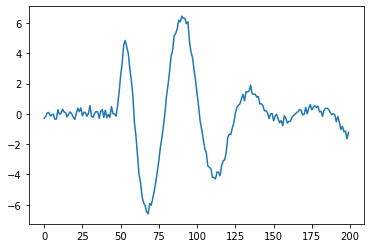

In [29]:
plt.plot(uxr[:,10])

In [30]:
import pywt
wvt = 'db12'
das_wvt_data = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in edasr.T])
nodal_wvt_data_x = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in uxr.T])
nodal_wvt_data_y = np.array([np.hstack(pywt.wavedec(d, wvt)) for d in uyr.T])

In [31]:
np.save("Testing/das_wvt_data.npy", das_wvt_data)
np.save("Testing/nodal_wvt_data_x.npy", nodal_wvt_data_x)
np.save("Testing/nodal_wvt_data_y.npy", nodal_wvt_data_y)
np.save("Testing/nfactor.npy", nfactor)

In [32]:
G = np.vstack([np.hstack([G1, G2]), np.hstack([G4, np.zeros(np.shape(G4))]), np.hstack([np.zeros(np.shape(G4)), G4])])

Gn = np.std(G)

G /= Gn

G3n = G3 / Gn

In [33]:
o1 = np.linalg.slogdet(G.T @ G)

In [34]:
def objective(u, lmbda, eps):
    GuG = G.T @ np.diag(u) @ G+eps*np.eye(G.shape[1])
    o1 = np.linalg.slogdet(GuG)[1]
    o2 = lmbda*np.max(np.diag(G @ np.linalg.solve(GuG, G.T)))
    return o2-o1

In [35]:
def test_obj(sta):
    uvec = np.zeros(64)
    uvec[sta-1] = 1.0
    u = np.hstack([np.ones(G1.shape[0]), uvec, uvec])
    lmbda = 1.0
    eps = 1e-2
    return objective(u, lmbda, eps)

In [36]:
test_obj(np.load("IncoherenceResults/seq_order.npy"))

23110.19326561424

In [37]:
def reconstruction(w, wvt_lens, wvt):
    starts = np.hstack([0,np.cumsum(wvt_lens)])
    wcoef = [w[starts[i]:starts[i+1]] for i in range(len(wvt_lens))]
    return pywt.waverec(wcoef, wvt)

In [38]:
wvt_tmp = pywt.wavedec(edasr.T[0], wvt)
wvt_lens = [len(wc) for wc in wvt_tmp]

In [39]:
B = [4, 8, 16, 32, 64]
n_repeats = 10
res = np.zeros((len(B), n_repeats))
ures = np.zeros((len(B), n_repeats))
sres = np.zeros(len(B))

val = np.zeros((len(B), n_repeats))
uval = np.zeros((len(B), n_repeats))
sval = np.zeros(len(B))

In [40]:
for i, Bi in enumerate(B):
    sresi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_seq.npy")
    sresxi = sresi[:G3.shape[1], :]
    sresyi = sresi[G3.shape[1]:, :]
    sxpredi = G3n @ sresxi
    sypredi = G3n @ sresyi
    stxpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in sxpredi]))
    stypredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in sypredi]))
    sres[i] = np.sqrt(np.mean(np.hstack([np.square(stxpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(stypredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2])))
    sval[i] = test_obj(np.load("IncoherenceResults/seq_order.npy")[:Bi])
    
#     mresi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_max.npy")
#     mresxi = mresi[:G3.shape[1], :]
#     mresyi = mresi[G3.shape[1]:, :]
#     mxpredi = G3n @ mresxi
#     mypredi = G3n @ mresyi
#     mtxpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in mxpredi]))
#     mtypredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in mypredi]))
#     mres[i] = np.sqrt(np.mean(np.hstack([np.square(mtxpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(mtypredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2])))
    for j in range(n_repeats):
        if Bi == 64:
            resi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_run_1.npy")
            uresi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_urun_1.npy")   
            val[i,j] = test_obj(np.load(f"Testing/LassoOutputInc/32B_{Bi}_run_1_sensors.npy"))
            uval[i,j] = test_obj(np.load(f"Testing/LassoOutputInc/32B_{Bi}_urun_1_sensors.npy"))
        else:
            resi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_run_{j+1}.npy")
            uresi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_urun_{j+1}.npy")
            val[i,j] = test_obj(np.load(f"Testing/LassoOutputInc/32B_{Bi}_run_{j+1}_sensors.npy"))
            uval[i,j] = test_obj(np.load(f"Testing/LassoOutputInc/32B_{Bi}_urun_{j+1}_sensors.npy"))
        
        resxi = resi[:G3.shape[1], :]
        resyi = resi[G3.shape[1]:, :]
        uresxi = uresi[:G3.shape[1], :]
        uresyi = uresi[G3.shape[1]:, :]
        
        xpredi = G3n @ resxi
        ypredi = G3n @ resyi
        uxpredi = G3n @ uresxi
        uypredi = G3n @ uresyi
        
        txpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in xpredi]))
        typredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in ypredi]))
        tuxpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in uxpredi]))
        tuypredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in uypredi]))
        
        res[i,j] = np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(typredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2])))#/np.std(np.hstack([cuxr, cuyr]))
        ures[i,j] = np.sqrt(np.mean(np.hstack([np.square(tuxpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(tuypredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2])))#/np.std(np.hstack([cuxr, cuyr]))


In [41]:
idxx = np.array([[i for i,_ in enumerate(B)] for j in range(10)])

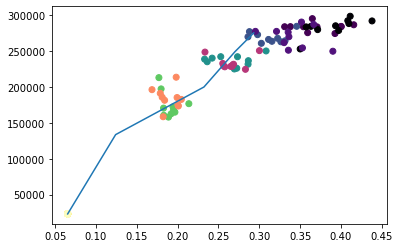

In [42]:
plt.scatter(res, val, c=idxx.T)
plt.scatter(ures, uval, c=idxx.T, cmap='magma')
plt.plot(sres, sval)

In [43]:
coloro = "#FF6C0C"
colorb = "#00A1DF"
colorgr = "#C8C8C8"
colorp = "#F54D80"

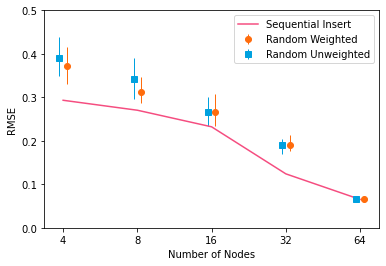

In [44]:
idx = np.array([i for i, Bi in enumerate(B)])
dx = 0.05
plt.figure(figsize=(6,4))
plt.errorbar(idx+dx, np.mean(res, axis=1), yerr=np.abs(np.mean(res, axis=1)-np.array([np.min(res,axis=1), np.max(res,axis=1)])), label="Random Weighted", marker="o", color=coloro, lw=0, elinewidth=1)
plt.errorbar(idx-dx,  np.mean(ures, axis=1), yerr=np.abs(np.mean(ures, axis=1)-np.array([np.min(ures,axis=1), np.max(ures,axis=1)])), label="Random Unweighted", marker="s", color=colorb, lw=0, elinewidth=1)
plt.plot(idx, sres, label="Sequential Insert", color=colorp)
# plt.plot(idx, mres, label="Maximum Weights", color=coloro)

plt.legend(loc="upper right")
plt.xticks(ticks=[i for i, Bi in enumerate(B)], labels=B)
plt.ylim((0.0,0.5))
plt.xlabel("Number of Nodes")
plt.ylabel("RMSE")
plt.savefig("OED_Outcome.pdf")

In [45]:
    rs = np.load(f"IncoherenceResults/seq_order.npy")


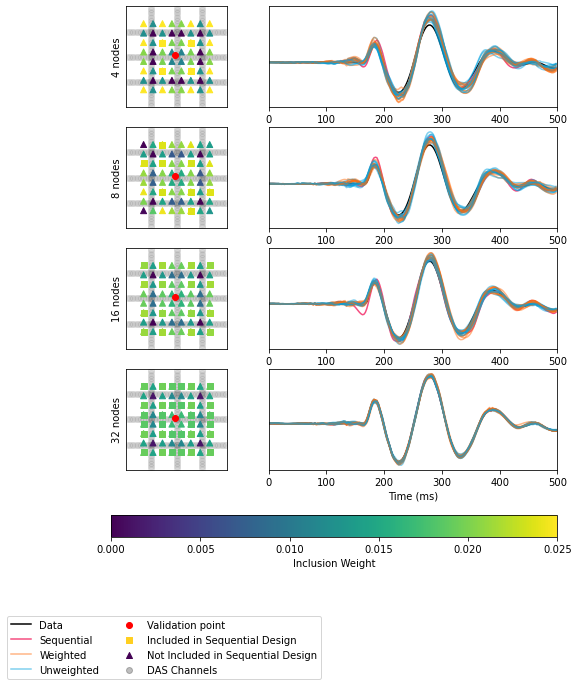

In [82]:
import matplotlib as mpl

fig = plt.figure(figsize=(8,11))
gs = fig.add_gridspec(4,3)
axs = []
norm = mpl.colors.Normalize(vmin=0.0,vmax=0.025)

for i, Bi in enumerate(B[:-1]):
    m_ax = fig.add_subplot(gs[i,0])
    res = np.load(f"IncoherenceResults/res_inc_{Bi}.npy")
    m_ax.scatter(das_x, das_y, c='k', alpha=0.05)
    cax = m_ax.scatter(xs2, ys2, c=res/Bi, marker='^', norm=norm)
    
    rs = np.load(f"IncoherenceResults/seq_order.npy")-1
    cax = m_ax.scatter(xs2[rs[:Bi]], ys2[rs[:Bi]], c=res[rs[:Bi]]/Bi, marker='s', norm=norm)
    m_ax.scatter([xs[135]], [ys[135]], c='red',marker='o')

    m_ax.set_xlim(0,320)
    m_ax.set_ylim(0,320)
#     plt.colorbar(cax, label="Inclusion Probability")
    m_ax.set_xticks([])
    m_ax.set_yticks([])
    m_ax.set_aspect("equal")
    m_ax.set_ylabel(f"{Bi} nodes")
    axs += [m_ax]
    
    
    p_ax = fig.add_subplot(gs[i,1:])
    p_ax.plot(tf[:-1]*1000, cuxr.T[135], color='k', label="Data")
    if i == 3:
        p_ax.set_xlabel("Time (ms)")
        
    p_ax.set_xlim(0,500)
    p_ax.set_yticks([])
#     p_ax.set_yticks([-5,0,5])
#     p_ax.set_ylabel("Displacement (arb.)")
    axs += [p_ax]
    
    sresi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_seq.npy")
    sresxi = sresi[:G3.shape[1], :]
    sxpredi = G3n @ sresxi
    stxpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in sxpredi]))
    p_ax.plot(tf[:-1]*1000, stxpredi[135], color=colorp, label="Sequential")
    for j in range(n_repeats):
        resi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_run_{j+1}.npy")
        uresi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_urun_{j+1}.npy")

        resxi = resi[:G3.shape[1], :]
        uresxi = uresi[:G3.shape[1], :]
        
        xpredi = G3n @ resxi
        uxpredi = G3n @ uresxi
        
        txpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in xpredi]))
        tuxpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in uxpredi]))
        if i == 0 and j == 0: 
            p_ax.plot(tf[:-1]*1000, txpredi[135], color=coloro, alpha=0.5, label="Weighted")
            p_ax.plot(tf[:-1]*1000, tuxpredi[135], color=colorb, alpha=0.5, label="Unweighted")
            p_ax.scatter([-100],[0], c="red",marker="o", label="Validation point")
            p_ax.scatter([-100],[0], c="#ffcf20FF",marker="s", label="Included in Sequential Design")
            p_ax.scatter([-100],[0], c="#440154FF",marker="^", label="Not Included in Sequential Design")
            p_ax.scatter([-100],[0], c='k', alpha=0.25, label="DAS Channels")


            p_ax.legend(bbox_to_anchor=(0.2, -5), ncol=2)
        else: 
            p_ax.plot(tf[:-1]*1000, txpredi[135], color=coloro, alpha=0.5, label="")
            p_ax.plot(tf[:-1]*1000, tuxpredi[135], color=colorb, alpha=0.5, label="")
            
fig.colorbar(cax, ax=axs, orientation="horizontal", label="Inclusion Weight", pad=0.075)
fig.savefig("OED_eval_results.pdf")

In [ ]:
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=0.0,vmax=0.6)
for i, Bi in enumerate(B):
    for j in range(n_repeats):
        if Bi == 256:
            resi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_run_1.npy")
            uresi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_urun_1.npy")        
        else:
            resi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_run_{j+1}.npy")
            uresi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_urun_{j+1}.npy")
        
        resxi = resi[:G3.shape[1], :]
        resyi = resi[G3.shape[1]:, :]
        uresxi = uresi[:G3.shape[1], :]
        uresyi = uresi[G3.shape[1]:, :]
        
        xpredi = G3n @ resxi
        ypredi = G3n @ resyi
        uxpredi = G3n @ uresxi
        uypredi = G3n @ uresyi
        
        txpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in xpredi]))
        typredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in ypredi]))
        tuxpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in uxpredi]))
        tuypredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in uypredi]))
        
        plt.figure()
        plt.scatter(das_x, das_y,color='k', alpha=0.25)
        plt.xlim(0,320)
        plt.ylim(0,320)
        plt.xlabel("Easting (m)")
        plt.ylabel("Northing (m)")
        plt.gca().set_aspect("equal")
        plt.title(f"{Bi} {j} weighted")
        cax = plt.scatter(xs, ys, c=np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(typredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2]), axis=1)), norm=norm)
        plt.colorbar(cax)
        
        plt.figure()
        plt.scatter(das_x, das_y,color='k', alpha=0.25)
        plt.xlim(0,320)
        plt.ylim(0,320)
        plt.xlabel("Easting (m)")
        plt.ylabel("Northing (m)")
        plt.gca().set_aspect("equal")
        plt.title(f"{Bi} {j} unweighted")
        cax = plt.scatter(xs, ys, c=np.sqrt(np.mean(np.hstack([np.square(tuxpredi-cuxr.T)/np.std(cuxr, axis=0)[:,np.newaxis]**2, np.square(tuypredi-cuyr.T)/np.std(cuyr, axis=0)[:,np.newaxis]**2]), axis=1)), norm=norm)
        plt.colorbar()

In [ ]:
j = 1
Bi = 16
resi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_run_{j+1}.npy")
uresi = np.load(f"Testing/LassoOutputInc/32B_{Bi}_urun_{j+1}.npy")

resxi = resi[:G3.shape[1], :]
resyi = resi[G3.shape[1]:, :]
uresxi = uresi[:G3.shape[1], :]
uresyi = uresi[G3.shape[1]:, :]

xpredi = G3n @ resxi
ypredi = G3n @ resyi
uxpredi = G3n @ uresxi
uypredi = G3n @ uresyi

txpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in xpredi]))
typredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in ypredi]))
tuxpredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in uxpredi]))
tuypredi = np.real(np.array([reconstruction(w, wvt_lens, wvt) for w in uypredi]))

res[i,j] = np.sqrt(np.mean(np.hstack([np.square(txpredi-cuxr.T), np.square(typredi-cuyr.T)])))/np.std(np.hstack([cuxr, cuyr]))
ures[i,j] = np.sqrt(np.mean(np.hstack([np.square(tuxpredi-cuxr.T), np.square(tuypredi-cuyr.T)])))/np.std(np.hstack([cuxr, cuyr]))

In [ ]:
plt.plot(cuxr.T[0])
plt.plot(txpredi[0])

In [ ]:
plt.plot(cuxr.T[0])
plt.plot(tuxpredi[0])

In [ ]:
residx = np.load(f"Testing/LassoOutputInc/32B_{Bi}_run_{j+1}_sensors.npy")
svec = np.zeros(64)
svec[residx-1] = 1
plt.scatter(das_x, das_y,color='k', alpha=0.5)
plt.scatter(xs2, ys2, marker='^', c=svec)
plt.xlim(0,320)
plt.ylim(0,320)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

In [ ]:
residx = np.load(f"Testing/LassoOutputInc/32B_{Bi}_urun_{j+1}_sensors.npy")
svec = np.zeros(64)
svec[residx-1] = 1
plt.scatter(das_x, das_y,color='k', alpha=0.5)
plt.scatter(xs2, ys2, marker='^', c=svec)
plt.xlim(0,320)
plt.ylim(0,320)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

In [ ]:
residx = np.load(f"IncoherenceResults/seq_order.npy")
svec = np.zeros(64)
svec[residx[:8]-1] = 1
plt.scatter(das_x, das_y,color='k', alpha=0.5)
plt.scatter(xs2, ys2, marker='^', c=svec)
plt.xlim(0,320)
plt.ylim(0,320)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")

In [ ]:
i = 8
res = np.load(f"IncoherenceResults/res_inc_{i}.npy")
residx = np.argpartition(res, -i)[-i:]
svec = np.zeros(64)
svec[residx] = 1
plt.scatter(das_x, das_y,color='k', alpha=0.5)
plt.scatter(xs2, ys2, marker='^', c=svec)
plt.xlim(0,320)
plt.ylim(0,320)
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.gca().set_aspect("equal")